**Connect with Google Drive**

In [ ]:
!/opt/bin/nvidia-smi

Wed Oct 21 12:06:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataPath = '/content/gdrive/My Drive/四上/AI_cup/'
import spacy
nlp = spacy.load('en_core_web_sm')

**Data processing**  

**刪除多於資訊 (Remove redundant information)**  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分刪除。  
In dataset, we reserved lots of information. But the mtehod we use in this tutorial doesn't need them, so let's delete it.

In [ ]:
import pandas as pd
dataset = pd.read_csv(dataPath+'task1_trainset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

**資料切割  (Partition)**  
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   
While training, we need some method to exam our model's performance, so we divide our training data into training/validation set.

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv(dataPath+'trainset.csv',index=False)
validset.to_csv(dataPath+'validset.csv',index=False)

In [ ]:
# Do the same things for test data
dataset = pd.read_csv(dataPath+'task1_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('testset.csv',index=False)

**統計單字 (Count words)**  
在訓練時，不能直接將單字直接餵入model，因為它只看得懂數字，因此我們必須把所有的單字抽取出來，並將它們打上編號，做出一個字典來對它們做轉換。
We can't feed "word" into model directly, since it can only recognize number. So, we need to know the total number of word, and give every word a unique number.  
在這裡，我們需要借助`nltk`這個library來幫忙做文字切割。當然，你也可以選擇自己寫規則來切割(通常上不建議搞死自己)。  
In here, we split words by using `nltk library`. You can write your own rules and split it by yourself, but you won't want to do that, trust me.  

In [ ]:
# colab doesn't have all package in nltk, we need to download by ourselves.
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np

tesee = pd.read_csv(dataPath+'sss.csv', dtype=str)
tesee.drop('Title',axis=1,inplace=True)
tesee.drop('Categories',axis=1,inplace=True)
tesee.drop('Created Date',axis=1, inplace=True)
tesee.drop('Authors',axis=1,inplace=True)
tesee.to_csv('sss1.csv',index=False)

In [ ]:
words = set()
def spacy_tokenizer(text):
  tokens = set()
  s = []
  doc = nlp(text)
  for i in doc:
    s.append(i.text)
  # print(s)
  # print(doc)
  tokens |= set(s)
  return tokens
  
string1 = "Apple is looking Apple is looking"
words |= spacy_tokenizer(string1)
words

{'Apple', 'is', 'looking'}

In [ ]:
words

{'Apple', 'is', 'looking'}

In [ ]:
def collect_words(data_path):
  df = pd.read_csv(data_path, dtype=str)
  # print(df)
  tokens = set()
  for i in df.iterrows():
    sents  = i[1]['Abstract'].split('$$$')
    # print(sents)
    sents = ' '.join(sents)
    tokens |= set(word_tokenize(sents))
    # print(word_tokenize(sents))
    # print(tokens)
    # type(tokens)
  return tokens

In [ ]:
words = set()
words |= collect_words(dataPath+'trainset.csv')
# words |= collect_words('sss1.csv')

In [ ]:
words = list(words)
len(words)

39903

**建立字典 (Building Dictionary)**  
Given every word a unique index.
```
pad: for padding  
unk: for word that not in our dicitonary
```



In [ ]:
PAD_TOKEN = 0
UNK_TOKEN = 1
word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}

In [ ]:
from torchtext.vocab import GloVe
from torchtext.data import Field
import torchtext
import torch
TEXT = Field(lower = True,batch_first=False,include_lengths=True)
TEXT.build_vocab([words],vectors = GloVe(name = '6B',dim = 50))
# TEXT.build_vocab([words],vector = FastText(language='en'))

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                           
100%|█████████▉| 399513/400000 [00:11<00:00, 37843.44it/s]

In [ ]:
TEXT.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'<unk>': 0,
             '<pad>': 1,
             '!': 2,
             '#': 3,
             '%': 4,
             '&': 5,
             "'": 6,
             "''": 7,
             "''causality": 8,
             "''ghosts": 9,
             "'11": 10,
             "'3dnaprinter": 11,
             "'An": 12,
             "'BioBlender": 13,
             "'Chaperone": 14,
             "'Complete": 15,
             "'De": 16,
             "'Digital": 17,
             "'Future-State": 18,
             "'ITOP": 19,
             "'Integer": 20,
             "'MASON": 21,
             "'New": 22,
             "'Our": 23,
             "'PGQL": 24,
             "'The": 25,
             "'UBC3V": 26,
             "'a": 27,
             "'acceptable": 28,
             "'agnostic": 29,
             "'b": 30,
             "'best-effort": 31,
             "'characteristic-by-characteristic": 32,
             "'codon": 33,
            

**資料格式化 (Data formatting)**  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

In [ ]:
def get_dataset(data_path, word_dict, n_workers=4):
  """ Load ㄋdata and return dataset for training and validating.

  Args:
      data_path (str): Path to the data.
  Return:
      output (list of dict): [dict, dict, dict ...]
  """
  dataset = pd.read_csv(data_path, dtype=str)
  formatData = []
  for (idx,data) in dataset.iterrows():
    """
    processed: {
      'Abstract': [[4,5,6],[3,4,2],...]
      'Label': [[0,0,0,1,1,0],[1,0,0,0,1,0],...]
    }
    """
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    if 'Task 1' in data:
      processed['Label'] = [label_to_onehot(label) for label in data['Task 1'].split(' ')]
    formatData.append(processed)
  
  return formatData
  
def label_to_onehot(labels):
  """ Convert label to onehot .
      Args:
          labels (string): sentence's labels.
      Return:
          outputs (onehot list): sentence's onehot label.
  """
  label_dict = {'BACKGROUND': 0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
  onehot = [0,0,0,0,0,0]
  for l in labels.split('/'):
    onehot[label_dict[l]] = 1
  # print(labels)
  return onehot
        
def sentence_to_indices(sentence, word_dict):
  """ Convert sentence to its word indices.
  Args:
      sentence (str): One string.
  Return:
      indices (list of int): List of word indices.
  """
  # 把word丟進字典裡尋找 有找到vocabulary就返回其key 沒有就返回unk_token
  return [word_dict.get(word,UNK_TOKEN) for word in word_tokenize(sentence)]


In [ ]:
print('[INFO] Start processing trainset...')
train = get_dataset(dataPath+'trainset.csv', TEXT.vocab.stoi, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset(dataPath+'validset.csv', TEXT.vocab.stoi, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset(dataPath+'task1_public_testset.csv', TEXT.vocab.stoi, n_workers=4)
# sss = get_dataset('sss1.csv', TEXT.vocab.stoi, n_workers=4)

[INFO] Start processing trainset...
[INFO] Start processing validset...
[INFO] Start processing testset...


**資料封裝 (Data loader)**  
為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  
To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing, and we will padding sentence in here.

In [ ]:
"""
Don't forget the data type that tidy up from get_dataset()!! 
Format: [dict, dict, ...]
dict:{
  'Abstract': [[4,5,6],[3,4,2],...]
  'Label': [[0,0,0,1,1,0],[1,0,0,0,1, 0],...] <-- testing data don't have this
}
"""
from torch.utils.data import Dataset
import torch
class AbstractDataset(Dataset):
  def __init__(self, data, pad_idx, max_len = 500):
    self.data = data
    self.pad_idx = pad_idx
    self.max_len = max_len
  def __len__(self):
    # print(len(self.data))
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]
      
  def collate_fn(self, datas):
    """
    returns:
    Tensor(batch,sentence,words) : input data
    Tensor(batch,sentence,words) : corresponding answer
    list(sentence quantity in each abstract): use in prediction, to remove the redundant sentences (the sentences we padded)
    
    """
    # get max length in this batch
    max_sent = max([len(data['Abstract']) for data in datas])
    max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
    batch_abstract = []
    batch_label = []
    sent_len = []
    for data in datas:
      # padding abstract to make them in same length
      pad_abstract = []
      for sentence in data['Abstract']:
        if len(sentence) > max_len:
          pad_abstract.append(sentence[:max_len])
        else:
          pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
      sent_len.append(len(pad_abstract))
      pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
      batch_abstract.append(pad_abstract)

      # gather labels
      if 'Label' in data:
          pad_label = data['Label']
          pad_label.extend([[0]*6]*(max_sent-len(pad_label)))
          batch_label.append(pad_label)

    return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

In [ ]:
trainData = AbstractDataset(train, PAD_TOKEN, max_len = 64)
validData = AbstractDataset(valid, PAD_TOKEN, max_len = 64)
testData = AbstractDataset(test, PAD_TOKEN, max_len = 64)
# sssData = AbstractDataset(sss, PAD_TOKEN, max_len = 64)
# print(type(sssData))

In [ ]:
validData

**Model**  

資料處理完成後，接下來就是最重要的核心部分：`Model`。  
此次範例中我們以簡單的一層RNN + 兩層Linear layer作為示範。  
而為了解決每次的句子長度不一的問題(`linear layer必須是fixed input size`)，因此我們取所有hidden_state裡, 每一個feature的最大值，讓這一個vector代表這句話。  

In this tutorial, we're going to implement a simple model, which contain one RNN layer and two fully connected layers (Linear layer). Of course you can make it "deep".  
To solve variant sentence length problem (`input size in linear layer must be fixed`), we can average all hidden_states or doing max pooling, and become one vector. (Perfect!)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class simpleNet(nn.Module):
  def __init__(self, vocabulary_size):
    super(simpleNet, self).__init__()
    self.embedding_size = 300
    self.hidden_dim = 512
    # self.hidden = 512
    self.embedding = nn.Embedding(vocabulary_size, self.embedding_size)
    self.sent_rnn = nn.GRU(self.embedding_size,
                            self.hidden_dim,
                            2,
                            dropout = 0.7,
                            bidirectional=True,
                            batch_first=True)
    self.l1 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
    self.l2 = nn.Linear(self.hidden_dim, 6)

  def forward(self, x):
    # x: (batch,sent,word)
    x = self.embedding(x)
    # x: (batch,sent,word,feature)
    b,s,w,e = x.shape
    x = x.view(b,s*w,e)
    # x: (batch,sent*word,feature)
    x , __ = self.sent_rnn(x)
    # x , __ = self.sent_rnn2(x)
    # x: (batch,sent*word,hidden_state*2)
    x = x.view(b,s,w,-1)
    # x: (batch,sent,word,hidden_state*2)
    x = torch.max(x,dim=2)[0]
    # x: (batch,sent,hidden_state*2)
    x = torch.relu(self.l1(x))
    x = torch.sigmoid(self.l2(x))
    # x: (batch,sent,6)
    return x

**Training**  
指定使用的運算裝置  
Designate running device.

In [ ]:
device='cuda'

定義計分公式, 讓我們在training能快速了解model的效能  
Define score function, let us easily observe model performance while training.  

In [ ]:
class F1():
  def __init__(self):
    self.threshold = 0.5
    self.n_precision = 0
    self.n_recall = 0
    self.n_corrects = 0
    self.name = 'F1'

  def reset(self):
    self.n_precision = 0
    self.n_recall = 0
    self.n_corrects = 0

  def update(self, predicts, groundTruth):
    predicts = (predicts > self.threshold).float()
    self.n_precision += torch.sum(predicts).data.item()
    self.n_recall += torch.sum(groundTruth).data.item()
    self.n_corrects += torch.sum(groundTruth * predicts).data.item()

  def get_score(self):
    recall = self.n_corrects / self.n_recall
    precision = self.n_corrects / (self.n_precision + 1e-20) #prevent divided by zero
    return 2 * (recall * precision) / (recall + precision + 1e-20)

  def print_score(self):
    score = self.get_score()
    return '{:.5f}'.format(score)


In [ ]:
import os
from tqdm import tqdm_notebook as tqdm
def _run_epoch(epoch, training):
  model.train(training)
  if training:
    description = 'Train'
    dataset = trainData
    shuffle = True
  else:
    description = 'Valid'
    dataset = validData
    shuffle = False
  dataloader = DataLoader(dataset=dataset,
               batch_size=64,
               shuffle=shuffle,
               collate_fn=dataset.collate_fn,
               num_workers=4)

  trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
  loss = 0
  f1_score = F1()
  for i, (x, y, sent_len) in trange:
    opt.zero_grad()

    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    print('label',o_labels.shape , o_labels)
    print(labels)
    batch_loss = criteria(o_labels, labels)

    if training:
      batch_loss.backward()
      opt.step()

    loss += batch_loss.item()
    f1_score.update(o_labels.cpu(), y)

    trange.set_postfix(
      loss=loss / (i + 1), f1=f1_score.print_score())
  if training:
      history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
  else:
      history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})


def save(epoch):
  if not os.path.exists(dataPath+'glove'):
    os.makedirs(dataPath+'glove')
        
  torch.save(model.state_dict(), dataPath+'glove/model.pkl.'+str(epoch))
  with open(dataPath+'glove/history.json', 'w') as f:
    json.dump(history, f, indent=4)

In [ ]:
TEXT.vocab.vectors.shape
# len(words)

torch.Size([39905, 50])

In [ ]:
model = simpleNet(len(TEXT.vocab.stoi))
# TEXT.vocab.vectors.shape
model.embedding.weight.data.copy_(TEXT.vocab.vectors)
model.embedding.weight.requires_grad = False
model

simpleNet(
  (embedding): Embedding(39905, 300)
  (sent_rnn): GRU(300, 512, num_layers=2, batch_first=True, dropout=0.7, bidirectional=True)
  (l1): Linear(in_features=1024, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=6, bias=True)
)

In [ ]:
from torch.utils.data import DataLoader
import json
opt = torch.optim.AdamW(model.parameters())
criteria = torch.nn.BCELoss()
model.to(device)
max_epoch = 7
history = {'train':[],'valid':[]}

for epoch in range(max_epoch):
  print('Epoch: {}'.format(epoch))
  _run_epoch(epoch, True)
  _run_epoch(epoch, False)
  save(epoch)

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


label torch.Size([64, 13, 6]) tensor([[[0.4865, 0.4912, 0.4853, 0.5007, 0.4908, 0.4916],
         [0.4855, 0.4816, 0.4791, 0.4932, 0.4913, 0.4900],
         [0.4923, 0.4865, 0.4803, 0.4901, 0.4914, 0.4910],
         ...,
         [0.4907, 0.4930, 0.4864, 0.5042, 0.4922, 0.4957],
         [0.4917, 0.4928, 0.4865, 0.5034, 0.4914, 0.4961],
         [0.4906, 0.4921, 0.4863, 0.5047, 0.4916, 0.4959]],

        [[0.4887, 0.4822, 0.4799, 0.4895, 0.4910, 0.4885],
         [0.4886, 0.4849, 0.4851, 0.4903, 0.4916, 0.4961],
         [0.4910, 0.4873, 0.4804, 0.4906, 0.4911, 0.4918],
         ...,
         [0.4925, 0.4930, 0.4867, 0.5042, 0.4912, 0.4956],
         [0.4914, 0.4937, 0.4863, 0.5037, 0.4908, 0.4960],
         [0.4914, 0.4916, 0.4858, 0.5043, 0.4922, 0.4965]],

        [[0.4873, 0.4923, 0.4917, 0.4964, 0.4868, 0.5000],
         [0.4866, 0.4807, 0.4762, 0.4856, 0.4932, 0.4909],
         [0.4874, 0.4869, 0.4836, 0.4949, 0.4946, 0.4950],
         ...,
         [0.4889, 0.4823, 0.4748, 0.490

KeyboardInterrupt: ignored

**Plot Learning Curve**  

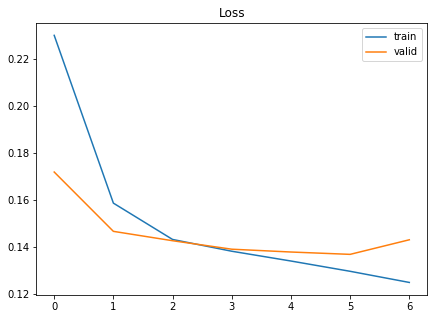

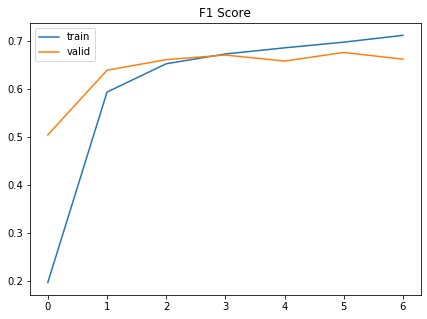

Best F1 score  [0.6759622937941869, 5]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

with open(dataPath+'glove/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))

**Choose your best model according to learning graph**

In [ ]:
# model.load_state_dict(torch.load(dataPath+'model/model.pkl.6'))

**Predict**  

In [ ]:
model.train(False)
dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x, y, sent_len) in trange:
  o_labels = model(x.to(device))
  o_labels = o_labels>0.5
  for idx, o_label in enumerate(o_labels):
    prediction.append(o_label[:sent_len[idx]].to('cpu'))
prediction = torch.cat(prediction).detach().numpy().astype(int)

In [ ]:
"""
Public = True if you're predicting public test data.
"""
import numpy as np
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
      submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
      submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
      submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
      submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
      submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
      submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
      submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
      submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
      submit['METHODS'] = [0]*redundant + list(prediction[:,2])
      submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
      submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
      submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [ ]:
SubmitGenerator(prediction,dataPath+'task1_sample_submission.csv',True, dataPath+'GloveGRUepoch_7_7.csv')